In [1]:
import pandas as pd
import os

import tensorflow as tf
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")  # ✅ désactive le GPU

# Charger le CSV
df = pd.read_csv("../data/dataset_selection_non_zoomer.csv")

# Aperçu du dataset
print("Aperçu du dataset :")
print(df.head())

print("\nInformations générales :")
print(df.info())


2026-01-22 00:15:42.621052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Aperçu du dataset :
                                                path     label
0  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
1  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
2  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
3  /home/mathis/Memoire/data/glaucome/LAG/LAG/Tra...  glaucome
4  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    6046 non-null   object
 1   label   6046 non-null   object
dtypes: object(2)
memory usage: 94.6+ KB
None


In [2]:
print(f"Nombre total d'images : {len(df)}")
print(f"Nombre de colonnes : {df.shape[1]}")


Nombre total d'images : 6046
Nombre de colonnes : 2


In [3]:
# Compter le nombre d'images par label
class_counts = df['label'].value_counts()

print("\nRépartition des labels :")
print(class_counts)

# Pourcentage par label
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage par label :")
print(class_percent.round(2))



Répartition des labels :
label
mda         1552
glaucome    1500
diabete     1500
normaux     1494
Name: count, dtype: int64

Pourcentage par label :
label
mda         25.67
glaucome    24.81
diabete     24.81
normaux     24.71
Name: proportion, dtype: float64


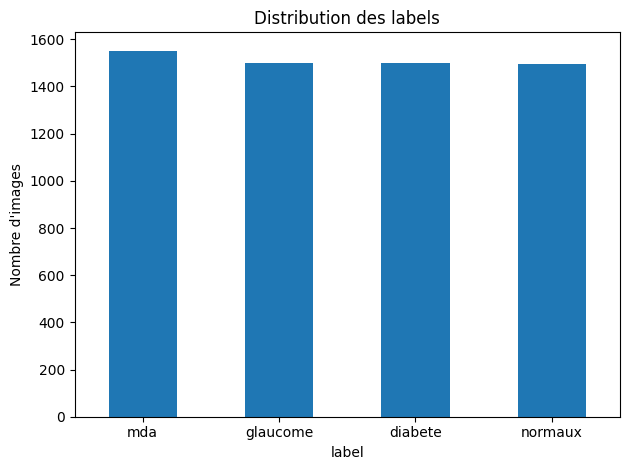

In [4]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribution des labels")
plt.xlabel("label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
for classe in df['label'].unique():
    print(f"\nExemples pour la classe '{classe}' :")
    print(df[df['label'] == classe]['path'].head(3).tolist())



Exemples pour la classe 'glaucome' :
['/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/glaucoma/1906.jpg', '/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/glaucoma/2695.jpg', '/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/glaucoma/0544.jpg']

Exemples pour la classe 'mda' :
['/home/mathis/Memoire/data/mda/Fundus/Fundus/ARMD/161.png', '/home/mathis/Memoire/data/mda/Fundus/Fundus/ARMD/328.png', '/home/mathis/Memoire/data/mda/Fundus/Fundus/ARMD/235.png']

Exemples pour la classe 'diabete' :
['/home/mathis/Memoire/data/diabete/train.zip/train/27895_right.jpeg', '/home/mathis/Memoire/data/diabete/train.zip/train/36728_left.jpeg', '/home/mathis/Memoire/data/diabete/train.zip/train/31549_left.jpeg']

Exemples pour la classe 'normaux' :
['/home/mathis/Memoire/data/mda/ODIR-5K/ODIR-5K/Training Images/2661_left.jpg', '/home/mathis/Memoire/data/glaucome/LAG/LAG/Training/normal/1940.jpg', '/home/mathis/Memoire/data/mda/fundus-dataset/00. Normal/img_0291.jpg']


In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test['label'],
    random_state=42
)




print("Tailles des splits :")
print(f"Train : {len(df_train)}")
print(f"Test : {len(df_test)}")
print(f"Validation : {len(df_val)}")

Tailles des splits :
Train : 4232
Test : 907
Validation : 907


In [7]:
def show_distribution(name, data):
    print(f"\n{name}")
    print(data['label'].value_counts(normalize=True).round(3))

show_distribution("Train", df_train)
show_distribution("Test", df_test)
show_distribution("Validation", df_val)



Train
label
mda         0.257
diabete     0.248
glaucome    0.248
normaux     0.247
Name: proportion, dtype: float64

Test
label
mda         0.257
glaucome    0.248
diabete     0.248
normaux     0.247
Name: proportion, dtype: float64

Validation
label
mda         0.257
diabete     0.248
glaucome    0.248
normaux     0.247
Name: proportion, dtype: float64


In [8]:
import numpy as np

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 42

# mapping label -> id (si label est texte)
classes = sorted(df_train["label"].unique().tolist())
label_to_id = {c:i for i,c in enumerate(classes)}

def df_to_ds(df, shuffle=False):
    paths = df["path"].astype(str).values
    labels = df["label"].map(label_to_id).astype(int).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)

    def load_and_preprocess(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)
        return img, label

    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # ✅ ignore les fichiers qui cassent decode_image
    ds = ds.apply(tf.data.experimental.ignore_errors())

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = df_to_ds(df_train, shuffle=True)
val_ds   = df_to_ds(df_val, shuffle=False)
test_ds  = df_to_ds(df_test, shuffle=False)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="aug")

#cnn
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(df['label'].unique()), activation='softmax')
])


early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
tf.config.optimizer.set_jit(False)   # désactive XLA globalement

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,   # ✅ évite graph/JIT => stoppe adam/Pow_* qui casse
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/home/mathis/Memoire/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    133/Unknown 113s 841ms/step - accuracy: 0.4672 - loss: 1.5579

2026-01-22 00:17:41.258614: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/mathis/Memoire/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


133/133 ━━━━━━━━━━━━━━━━━━━━ 119s 886ms/step - accuracy: 0.5560 - loss: 1.0851 - val_accuracy: 0.6637 - val_loss: 0.8101
Epoch 2/50


2026-01-22 00:17:47.215642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 106s 794ms/step - accuracy: 0.6420 - loss: 0.8062 - val_accuracy: 0.7089 - val_loss: 0.7031
Epoch 3/50


2026-01-22 00:19:32.943761: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 106s 799ms/step - accuracy: 0.6652 - loss: 0.7503 - val_accuracy: 0.7045 - val_loss: 0.6825
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 111s 827ms/step - accuracy: 0.6848 - loss: 0.7027 - val_accuracy: 0.7222 - val_loss: 0.6509
Epoch 5/50


2026-01-22 00:23:10.425896: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 108s 813ms/step - accuracy: 0.6985 - loss: 0.6684 - val_accuracy: 0.7398 - val_loss: 0.6073
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 109s 819ms/step - accuracy: 0.7056 - loss: 0.6564 - val_accuracy: 0.7266 - val_loss: 0.6525
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 111s 834ms/step - accuracy: 0.7226 - loss: 0.6388 - val_accuracy: 0.7541 - val_loss: 0.5960
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 109s 817ms/step - accuracy: 0.7342 - loss: 0.6148 - val_accuracy: 0.7530 - val_loss: 0.5931
Epoch 9/50


2026-01-22 00:30:27.357214: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 145s 821ms/step - accuracy: 0.7342 - loss: 0.6034 - val_accuracy: 0.7563 - val_loss: 0.5838
Epoch 10/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 111s 831ms/step - accuracy: 0.7398 - loss: 0.5769 - val_accuracy: 0.7619 - val_loss: 0.5593
Epoch 11/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 113s 850ms/step - accuracy: 0.7507 - loss: 0.5732 - val_accuracy: 0.7233 - val_loss: 0.6076
Epoch 12/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 113s 852ms/step - accuracy: 0.7550 - loss: 0.5592 - val_accuracy: 0.7652 - val_loss: 0.5621
Epoch 13/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 101s 761ms/step - accuracy: 0.7521 - loss: 0.5550 - val_accuracy: 0.7773 - val_loss: 0.5319
Epoch 14/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 102s 765ms/step - accuracy: 0.7550 - loss: 0.5556 - val_accuracy: 0.7321 - val_loss: 0.5894
Epoch 15/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 101s 761ms/step - accuracy: 0.7661 - loss: 0.5423 - val_accuracy: 0.7519 - val_loss: 0.5965
Epoch 16/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 102s 763ms/step - accuracy: 0.7694 - los

2026-01-22 00:45:15.929779: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 101s 757ms/step - accuracy: 0.7618 - loss: 0.5354 - val_accuracy: 0.7453 - val_loss: 0.6239
Epoch 18/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 101s 759ms/step - accuracy: 0.7743 - loss: 0.5200 - val_accuracy: 0.7563 - val_loss: 0.5939



=== Scores globaux ===
Accuracy            : 0.7607
Balanced accuracy   : 0.7606
Precision (macro)   : 0.7521
Recall (macro)      : 0.7606
F1 (macro)          : 0.7498
Precision (weighted): 0.7532
Recall (weighted)   : 0.7607
F1 (weighted)       : 0.7504

=== Rapport par classe ===
              precision    recall  f1-score   support

     diabete       0.72      0.92      0.81       225
    glaucome       0.88      0.95      0.91       225
         mda       0.85      0.74      0.79       233
     normaux       0.56      0.43      0.49       224

    accuracy                           0.76       907
   macro avg       0.75      0.76      0.75       907
weighted avg       0.75      0.76      0.75       907



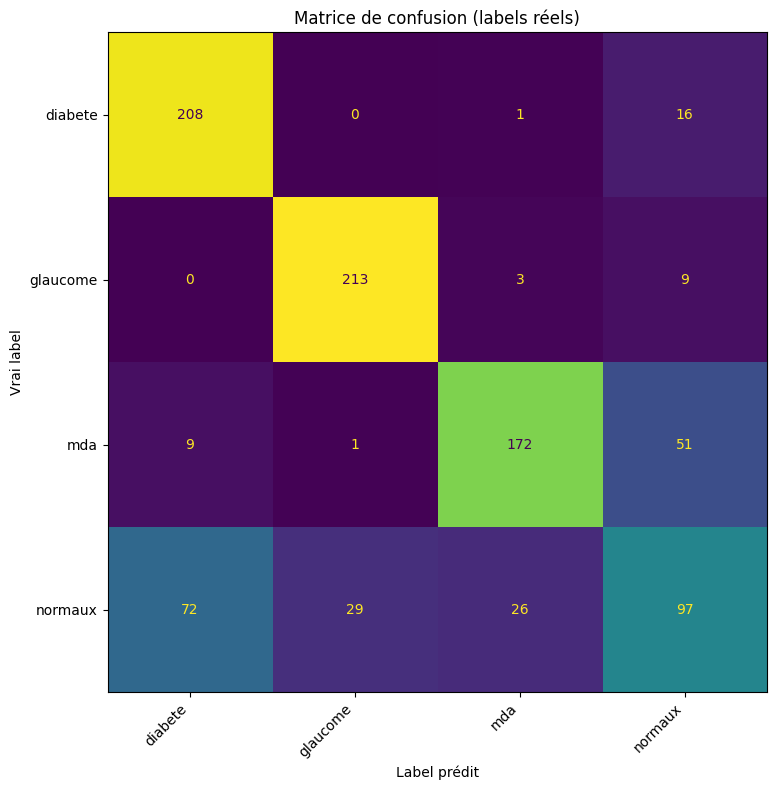

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    classification_report
)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

proba = model.predict(test_ds, verbose=0)
y_pred = np.argmax(proba, axis=1)
num_classes = len(classes)

# ----------------------------
# 7) METRICS
# ----------------------------
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print("\n=== Scores globaux ===")
print(f"Accuracy            : {acc:.4f}")
print(f"Balanced accuracy   : {bacc:.4f}")
print(f"Precision (macro)   : {prec_macro:.4f}")
print(f"Recall (macro)      : {rec_macro:.4f}")
print(f"F1 (macro)          : {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f}")
print(f"Recall (weighted)   : {rec_weighted:.4f}")
print(f"F1 (weighted)       : {f1_weighted:.4f}")

print("\n=== Rapport par classe ===")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

# ----------------------------
# 8) CONFUSION MATRIX (labels réels, ordre forcé)
# ----------------------------
label_indices = list(range(num_classes))
cm = confusion_matrix(y_true, y_pred, labels=label_indices)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, values_format="d", cmap=None, colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Label prédit")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion (labels réels)")
plt.tight_layout()
plt.show()
